**Abstract**(What is the question)

In astronomy, stellar classification is the classification of stars based on their spectral
characteristics. The classification scheme of galaxies, quasars, and stars is one of the most
fundamental in astronomy. This notebook aims to classify stars, galaxies, and quasars based
on their spectral characteristics in a reasonable and detailed way.


What did I do:
> In following part I will analysis data to understand the meaning of dataset.Then, I will clean empty data, outlier and correlated data, to make sure the reliability of dataset. Also, I will find the most important features and reduce the the influence of irrelative varibles. Even though this is a classification question, I still analyzed the distribution of the dependent and independent varibles. After study, I now understand I should analysis class-imbalance rather than distribution.

> I built 3 models and interpreted their paramters. Becaused I chosed a multi-class classification problem, so some explaination will be a little complex.

**Include packages and deal with data**

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 8.6 MB/s 


In [ ]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv("/content/star_classification.csv")

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


To solve the problem, we need to deal with data firstly.

# ML Data Cleaning and Feature Selection

**Data Explaination**

This dataset is a stellar classification dataset. As we are not so familar with stellar, we need explian some factors.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = pd.read_csv("/star_classification.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In this dataset, 'alpha' and 'delta' are angels, so they ranges from 0 to 360. The 'u' stand for ultraviolet filter. 'g' means green fliter, 'r' is red filter, and 'z' is infrared filter. rerun_ID is run number to identify the specific scan, it's different for every single star, so it's helpless for our result. Rerun_ID is a rerun number to indicate how the image was processed, it's not useful for our prediction. 'cam_col' is Camera column to identify the scaline within the run. Field_ID means which field the star is in. Spec_obj_ID is a unique number for every star. Redshift is the bias in wavelength when light travel, which is very important in astronomy. The 'plate' is a plate ID, indentifies plates in SDSS. MJD is Modified Julian Date about record. Fiber_ID indentifies the fiber pointed the light at focal plane in each observation.

In [ ]:
data['class'].describe()

count     100000
unique         3
top       GALAXY
freq       59445
Name: class, dtype: object

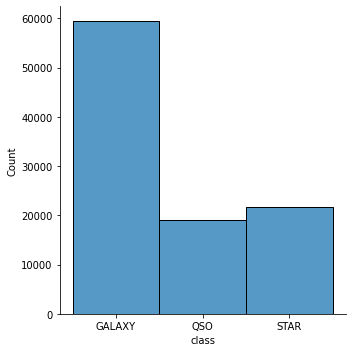

In [ ]:
sns.displot(data['class'])

**Which independent variables are useful to predict a target?**

We can have a conclusion from the introduction of varbiables above, obj_ID,run_ID, rerun_ID, spec_obj_ID, MJD are not helpful for our prediction. We will drop them in model building. In following part we will discuss 3 methods to select feature

1、Caculating F socre and p-value

In [ ]:
from sklearn.feature_selection import f_classif
tmp = data
value = {'GALAXY':0, 'QSO':1, 'STAR':2}
data['y'] = data['class'].map(value)
x = data.drop(['class','y'],axis=1)
y = data[['y']]
fs = f_classif(x,y)
table = pd.DataFrame(columns=['f_score','p_value'])
col = []
p_value = []
f_score = []
data = data.drop(['class','y'],axis=1)
for i in range(len(data.columns)-1):
    col.append(data.columns[i])
    f_score.append(fs[0][i])
    p_value.append(fs[1][i])

table['col'] = col
table['f_score'] = f_score
table['p_value'] = p_value
print(table)
data = tmp


         f_score       p_value          col
0     122.468215  7.546811e-54       obj_ID
1      21.948822  2.950117e-10        alpha
2     217.588357  5.100401e-95        delta
3      30.445339  6.050362e-14            u
4      25.962523  5.340060e-12            g
5    4584.533364  0.000000e+00            r
6    8282.343545  0.000000e+00            i
7      32.328308  9.215764e-15            z
8     122.550340  6.953186e-54       run_ID
9            NaN           NaN     rerun_ID
10     26.964839  1.960993e-12      cam_col
11     79.698400  2.600052e-35     field_ID
12   5169.594515  0.000000e+00  spec_obj_ID
13  83429.418967  0.000000e+00     redshift
14   5169.585517  0.000000e+00        plate
15   4427.629371  0.000000e+00          MJD


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


2、Pearson correlation

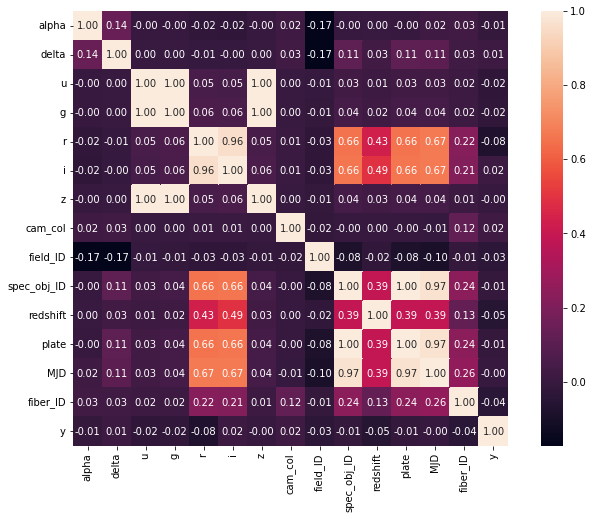

In [ ]:
from matplotlib import figure
tmp = data
value = {'GALAXY':0, 'QSO':1, 'STAR':2}
data['y'] = data['class'].map(value)
x = data.drop(['class','obj_ID','rerun_ID','run_ID'],axis=1)
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(x.corr(),annot=True, square=True,fmt='0.2f',ax=ax)
plt.show()
data = tmp

Because this is a classification question, so the result is not continuous, which result Pearson correlation act badly at y value.

Tree-based feature selection

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
X = x.drop(['y'],axis=1)
print(X.shape)

clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
print(clf.feature_importances_)  

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

(100000, 14)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


[0.03169445 0.02785891 0.07924083 0.07801984 0.04464088 0.05923171
 0.07001807 0.01348018 0.0154942  0.05746606 0.40206588 0.05520129
 0.05233487 0.01325282]
(100000, 3)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


We can calculate the importance and select most important features, which are redshift(0.402) and u(0.079).

**Missing values**

In [ ]:
data.shape

(100000, 18)

In [ ]:
data.isnull().sum().sort_values(ascending=False)

obj_ID         0
alpha          0
MJD            0
plate          0
redshift       0
class          0
spec_obj_ID    0
field_ID       0
cam_col        0
rerun_ID       0
run_ID         0
z              0
i              0
r              0
g              0
u              0
delta          0
fiber_ID       0
dtype: int64

As we can see from above result, this dataset has no missing values.

**Same data in test and training dataset**

We will split the dataset into training data and testing data, so we will check if there are any duplicated rows in dataset. Before detecting, we need to drop unique but useless columns like "obj_ID" 

In [ ]:
data_check = data.drop(columns="obj_ID")
data_check = data_check.drop(columns="spec_obj_ID")
data_check = data_check.drop(columns="rerun_ID")
data_check = data_check.drop(columns="run_ID")
data_check[data_check.duplicated()]

,alpha,delta,u,g,r,i,z,cam_col,field_ID,class,redshift,plate,MJD,fiber_ID


As we can see from result, the dataset has no duplicated row, which means the training and testing dataset will not have the same data.

**correlation between predictor variables**

We can draw a heatmap to check the correlation between predictor varibles.

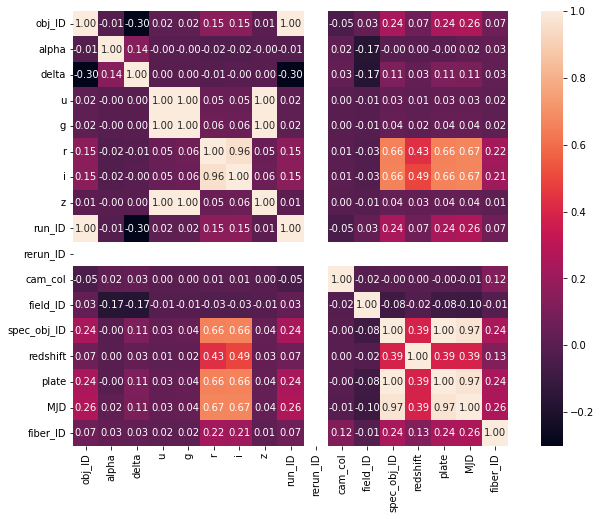

In [ ]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(data.corr(),annot=True, square=True,fmt='0.2f',ax=ax)
plt.show()

From heatmap above we can tell that features u,g,z have a close correlation. Also, feature r, i have a close correlation. And spec_obj_ID, plate, MJD have a close corrlation.

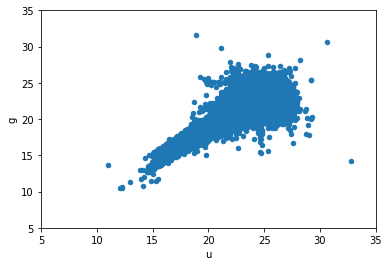

In [ ]:
var = "u"
draw_data = pd.concat([data['g'],data[var]],axis=1)
draw_data.plot.scatter(x=var, y='g', ylim=(5,35), xlim=(5,35))

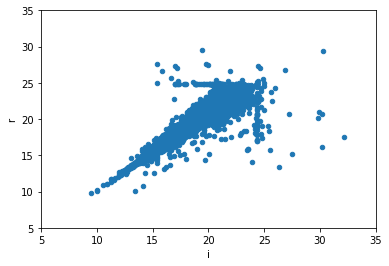

In [ ]:
var = "i"
draw_data = pd.concat([data['r'],data[var]],axis=1)
draw_data.plot.scatter(x=var, y='r', ylim=(5,35), xlim=(5,35))

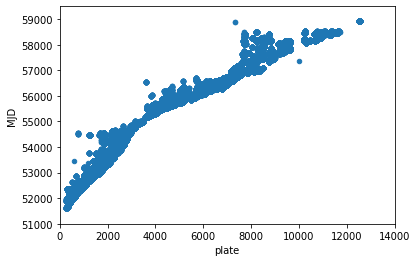

In [ ]:
var = "plate"
draw_data = pd.concat([data['MJD'],data[var]],axis=1)
draw_data.plot.scatter(x=var, y='MJD', xlim=(0,14000), ylim=(51000,59500))

In conclusion, variables are not indepentent of all the other predictor variables.

**Most Important varible**

In privious part, we used F-score and p-value to estimate the importance of variables, and we used Tree-based feature selection to figure out which variables are the best for model. From above test, we can tell redshift is the most important varible for the model.

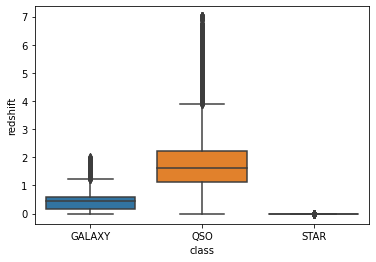

In [ ]:
fig = sns.boxplot(x="class",y="redshift",data=data)

**Ranges of predictor varibles**

We introduced factors in the first part of this report, we can see that alpha and delta are between 0 to 360 

In [ ]:
data[data['alpha']<0]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID,y


In [ ]:
data[data['alpha']>360]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID,y


In [ ]:
data[data['delta']<0]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID,y
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775,0
14,1.237663e+18,344.984770,-0.352616,23.20911,22.79291,22.08589,21.86282,21.85120,4192,301,3,255,1.037539e+19,GALAXY,0.818160,9215,57682,796,0
28,1.237663e+18,333.311511,-0.376123,20.53324,18.84066,18.05369,17.60397,17.29030,4192,301,3,177,1.164231e+18,GALAXY,0.091085,1034,52813,184,0
29,1.237663e+18,337.093435,-0.311773,20.15491,18.37295,17.31276,16.82294,16.44342,4192,301,3,203,4.234019e+17,GALAXY,0.148228,376,52143,231,0
52,1.237663e+18,341.391899,-0.317673,22.92673,23.03158,22.75313,21.40591,20.70943,4192,301,3,231,1.036622e+19,GALAXY,0.820115,9207,57667,206,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99973,1.237679e+18,29.011965,-2.182744,23.18446,22.82468,20.92415,19.93507,19.67807,7780,301,4,95,4.896731e+18,GALAXY,0.501251,4349,55803,699,0
99976,1.237656e+18,220.130847,-2.842318,19.45120,17.45974,16.36467,15.88998,15.49949,2379,301,2,73,1.035907e+18,GALAXY,0.118274,920,52411,288,0
99993,1.237653e+18,0.740551,-9.184243,23.13172,23.18506,21.52854,20.26975,20.11383,1740,301,5,27,8.069569e+18,GALAXY,0.617036,7167,56604,889,0
99994,1.237663e+18,317.246996,-0.682254,20.96526,19.81625,19.34186,19.14711,19.05790,4187,301,2,64,1.154061e+18,GALAXY,0.175206,1025,53239,51,0


In [ ]:
data[data['delta']>360]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID,y


**Distribution of variables**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


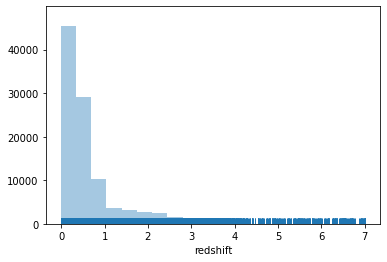

In [ ]:
sns.distplot(data['redshift'], bins=20, kde=False, rug=True);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


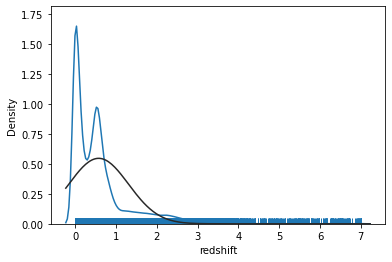

In [ ]:
sns.distplot(data['redshift'], hist=False, rug=True, fit=norm);

Redshift is not normal distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


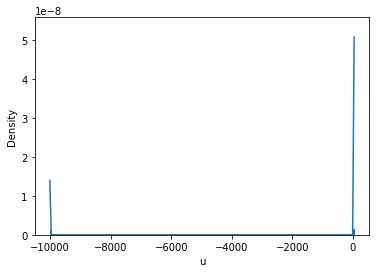

In [ ]:
sns.distplot(data['u'], hist=False, rug=True);

From picture above, we can see feature 'u' may have some outliars, we may need to drop -10000

In [ ]:
indices = data[data['u']<0].index
print(indices)

Int64Index([79543], dtype='int64')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


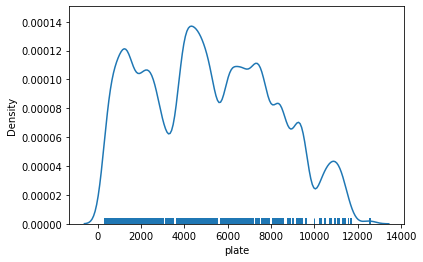

In [ ]:
sns.distplot(data['plate'], hist=False, rug=True);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


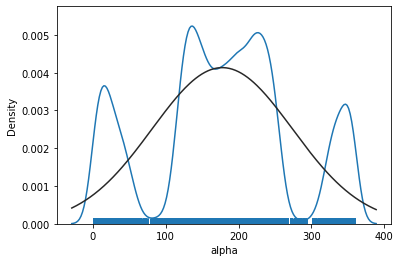

In [ ]:
sns.distplot(data['alpha'], hist=False, rug=True, fit=norm);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


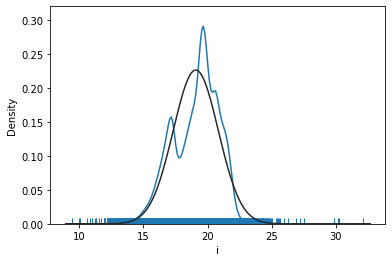

In [ ]:
sns.distplot(data['i'], hist=False, rug=True, fit=norm);

In conclusion, i is normal distribution, other are not.

**Remove 10% imputing**

1、Mean imputing

In [ ]:
missing_pct = int(data.columns.size*0.1)
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(data)
imputed_data = imp_mean.transform(data)

2、Most frequent imputing

In [ ]:
imp_mean = SimpleImputer(strategy='most frequent')
imp_mean.fit(data)
imputed_data = imp_mean.transform(data)

3、Do nothing
Some algorithms will slove this problem, like XGBoost.

After dealing with data, we will build up models and analysis the model we built.

# Model Interpretability

In [ ]:
data['class'].value_counts()
train = data.sample(frac=0.7, random_state=30)
test = data.drop(train.index)

value = {'GALAXY':1, 'QSO':2, 'STAR':0}

train['y'] = train['class'].map(value)
test['y'] = test['class'].map(value)

x_train = train.drop(['class','y'],axis=1)
y_train = train['y']
x_test = test.drop(['class','y'],axis=1)
y_test = test['y']

**Linear Model**

In this case, we are going to classify 3 different types of stellar. As we discussed in the last assignment, the classification of stellar have a strong relationship with redshift. Also, some variables have corrlations, I will use the selected features from the last assignment. 

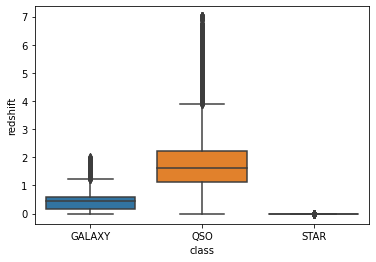

In [ ]:
fig = sns.boxplot(x="class",y="redshift",data=data)

In this case, we can fit this classification question into a logistic regression model. I chose the OVO instead of OVR model for accuracy.

In [ ]:
x_train = train[['redshift','i','delta']]
x_test = test[['redshift','i','delta']]
lr_model = LogisticRegression(C=0.1,random_state=20,solver='saga',tol=0.1,multi_class='multinomial')
lr_model.fit(x_train,y_train.values.ravel())
sparsity = np.mean(lr_model.coef_==0)*100
score = lr_model.score(x_test,y_test)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)
print("coef:")
print(lr_model.coef_)

Sparsity with L1 penalty: 0.00%
Test score with L1 penalty: 0.9307
coef:
[[-4.79831161e+00  9.60086239e-02 -3.51579443e-03]
 [ 4.54353215e-01  3.96931685e-02 -1.75603754e-03]
 [ 4.34395840e+00 -1.35701792e-01  5.27183197e-03]]


We got 3 softmax classifiers for this multi-classification problem. 3 classifiers stand for 3 different y values, which in this case are types of stellar. When the model is dealing with data, it will use 3 classifiers to calculate 3 probabilities, and find the biggest value, finally return the classifier of this biggest value. 

We can plot coefficient importance for each classifier. Firstly, we will start with classifier 0, this means, if this classifier gets the max probability, then we will have 0 as y-value, in this case, means this stellar is a star.

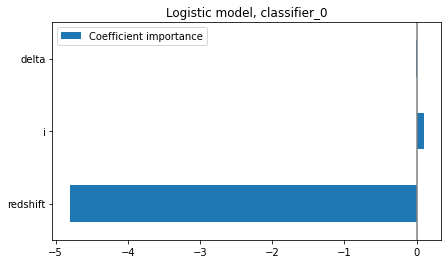

In [ ]:
feature_names = ['redshift','i','delta']
coefs_0 = pd.DataFrame(
    lr_model.coef_[0],
    columns=['Coefficient importance'], index=feature_names
)
coefs_0.plot(kind='barh', figsize=(9,4))
plt.title('Logistic model, classifier_0')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Then we plot classifier_1, if this classifier returns the max value, this stellar will be predicted as a galaxy.

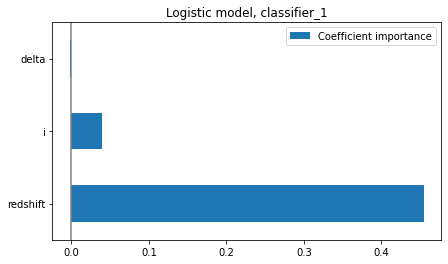

In [ ]:
feature_names = ['redshift','i','delta']
coefs_1 = pd.DataFrame(
    lr_model.coef_[1],
    columns=['Coefficient importance'], index=feature_names
)
coefs_1.plot(kind='barh', figsize=(9,4))
plt.title('Logistic model, classifier_1')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

The last classifier is classifier_2, this classifier stands for QSO

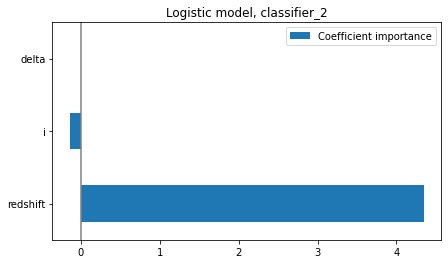

In [ ]:
feature_names = ['redshift','i','delta']
coefs_2 = pd.DataFrame(
    lr_model.coef_[2],
    columns=['Coefficient importance'], index=feature_names
)
coefs_2.plot(kind='barh', figsize=(9,4))
plt.title('Logistic model, classifier_2')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

As we can see from result above, redshift have a significant effect on prediction results. If some of variables changed a lot, it may have more effect on coefficients, we want to exclude this influence, so we add std(standard diviation) into consideration.

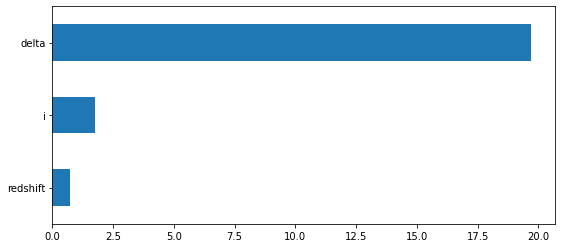

In [ ]:
x_train.std(axis=0).plot(kind='barh',figsize=(9,4))

**Tree Model**

In this part I will use sklearn tree-based classifier to build up a model, and explain every node of the tree.

In [ ]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.feature_selection import SelectFromModel


print(x_train.shape)

clf = ExtraTreeClassifier()
clf = clf.fit(x_train, y_train)
print(clf.feature_importances_)  

clf_feature = SelectFromModel(clf, prefit=True)
X_new = clf_feature.transform(x_train)
print(X_new.shape)

new_test = clf_feature.transform(x_test)
clf = clf.fit(X_new, y_train)
clf_score = clf.score(new_test,y_test)
print(clf_score)

(70000, 17)
[0.02130178 0.03295812 0.0145853  0.09480548 0.03267284 0.01900376
 0.0442013  0.04788131 0.01611629 0.         0.00982003 0.00971301
 0.02324531 0.50223268 0.06218849 0.06029011 0.00898419]
(70000, 4)
0.9453666666666667


X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names


The following part is to explain the function of every node

In [ ]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

Streaming output truncated to the last 5000 lines.
																							node=11601 is a leaf node.
																					node=11602 is a leaf node.
																				node=11603 is a leaf node.
																	node=11604 is a split node: go to node 11605 if X[:, 0] <= 22.53761811734459 else to node 11780.
																		node=11605 is a split node: go to node 11606 if X[:, 1] <= 22.315763130016602 else to node 11759.
																			node=11606 is a split node: go to node 11607 if X[:, 3] <= 0.8570822788360307 else to node 11712.
																				node=11607 is a split node: go to node 11608 if X[:, 1] <= 21.810551256696847 else to node 11661.
																					node=11608 is a split node: go to node 11609 if X[:, 2] <= 21.43095271446323 else to node 11660.
																						node=11609 is a split node: go to node 11610 if X[:, 4] <= 57235.59824503334 else to node 11623.
																							node=11610 is a split node: go to node 11611 if X[:, 1] <= 21.36064798492397 el

**AutoML The Best Model**

In this case, I used H2O.ai as autoML method, before we use H2O to find the best model, we will compare two models we built above by their accuracy and logistic loss 

In [ ]:
from sklearn.model_selection import cross_val_score
clf_score = cross_val_score(clf, new_test, y_test, scoring='accuracy')
lr_score = cross_val_score(lr_model, x_test, y_test, scoring='accuracy')
print("The score of tree_based classifer:")
print(clf_score)
print("The score of linear classifier classifer:")
print(lr_score)

The score of tree_based classifer:
[0.9425     0.946      0.94616667 0.94666667 0.93466667]
The score of linear classifier classifer:
[0.725      0.72283333 0.72866667 0.7275     0.723     ]


In [ ]:
clf_score = cross_val_score(clf, new_test, y_test, scoring='neg_log_loss')
lr_score = cross_val_score(lr_model, x_test, y_test, scoring='neg_log_loss')
print("The score of tree_based classifer:")
print(clf_score)
print("The score of linear classifier classifer:")
print(lr_score)

The score of tree_based classifer:
[-1.84782454 -1.87660685 -1.90538916 -2.04354427 -1.72118236]
The score of linear classifier classifer:
[-0.52830661 -0.52903119 -0.52721924 -0.51929495 -0.52730182]


And then install h2o library, and initial the h2o

In [ ]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 177.0 MB 19 kB/s 
  Created wheel for h2o: filename=h2o-3.36.1.1-py2.py3-none-any.whl size=177068062 sha256=e8a27a18366d697b9d4fb2a47e0d623f2c33146bb719a81546cf46bb855e9295
  Stored in directory: /root/.cache/pip/wheels/a6/d9/ab/5442447c7e2ccf07f66aa8b79f3877ce5382f0b95e6c0c797b
Successfully built h2o


In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14.1" 2022-02-08; OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpaiu48f1f
  JVM stdout: /tmp/tmpaiu48f1f/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpaiu48f1f/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_unknownUser_p0js7a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


We can use autoML to built many models and select the best model, in following part, I built 7 models and find the best one

In [ ]:
train_factor = train.drop(['y'],axis=1)
x = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'plate', 'MJD']
y = "class"
train_factor=h2o.H2OFrame(train_factor)
print(x)

# For binary classification, response should be a factor

# Run AutoML for 20 base models
aml = H2OAutoML(max_models=3)
aml.train(x=x, y=y, training_frame=train_factor)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'plate', 'MJD']
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,mean_per_class_error,logloss,rmse,mse
GBM_1_AutoML_1_20220425_00227,0.0270117,0.0696145,0.131008,0.0171631
StackedEnsemble_BestOfFamily_1_AutoML_1_20220425_00227,0.0271396,0.0680562,0.129594,0.0167945
XGBoost_1_AutoML_1_20220425_00227,0.0274059,0.0717163,0.131546,0.0173044
GLM_1_AutoML_1_20220425_00227,0.45115,0.645787,0.473026,0.223754


In [ ]:
m = aml.get_best_model()
test_factor = test.drop(['y'],axis=1)
test_factor=h2o.H2OFrame(test_factor)
performance = m.model_performance(test_factor)
performance

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%

ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.017619279810026502
RMSE: 0.13273763524346252
LogLoss: 0.07083387922467138
Mean Per-Class Error: 0.028374905614152568
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,GALAXY,QSO,STAR,Error,Rate
0,17550.0,206.0,30.0,0.013269,"236 / 17,786"
1,403.0,5342.0,1.0,0.070310,"404 / 5,746"
2,10.0,0.0,6458.0,0.001546,"10 / 6,468"
3,17963.0,5548.0,6489.0,0.021667,"650 / 30,000"



Top-3 Hit Ratios: 


,k,hit_ratio
0,1,0.978333
1,2,0.999967
2,3,1.000000


**SHAP**

In this part, I will use SHAP to interprete 3 models I built above. Some results of code cells could be very long, please scroll down inside the cell to view the whole result.

Linear Model

In [ ]:
sample = shap.sample(x_test, 10) 

In [ ]:
shap.initjs()
explainer = shap.KernelExplainer(lr_model.predict_proba, x_train)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value[0], shap_values[0], sample)

X does not have valid feature names, but LogisticRegression was fitted with feature names
Using 70000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Tree Model

In [ ]:
shap.initjs()
explainer = shap.KernelExplainer(clf.predict_proba, X_new)
sample = shap.sample(new_test, 30) 
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value[0], shap_values[0], sample)

Using 70000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/30 [00:00<?, ?it/s]

AutoML Model

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_1_AutoML_1_20220425_00227


Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,GALAXY,QSO,STAR,Error,Rate
0,17550.0,206.0,30.0,0.013269,"236 / 17,786"
1,403.0,5342.0,1.0,0.070310,"404 / 5,746"
2,10.0,0.0,6458.0,0.001546,"10 / 6,468"
3,17963.0,5548.0,6489.0,0.021667,"650 / 30,000"


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

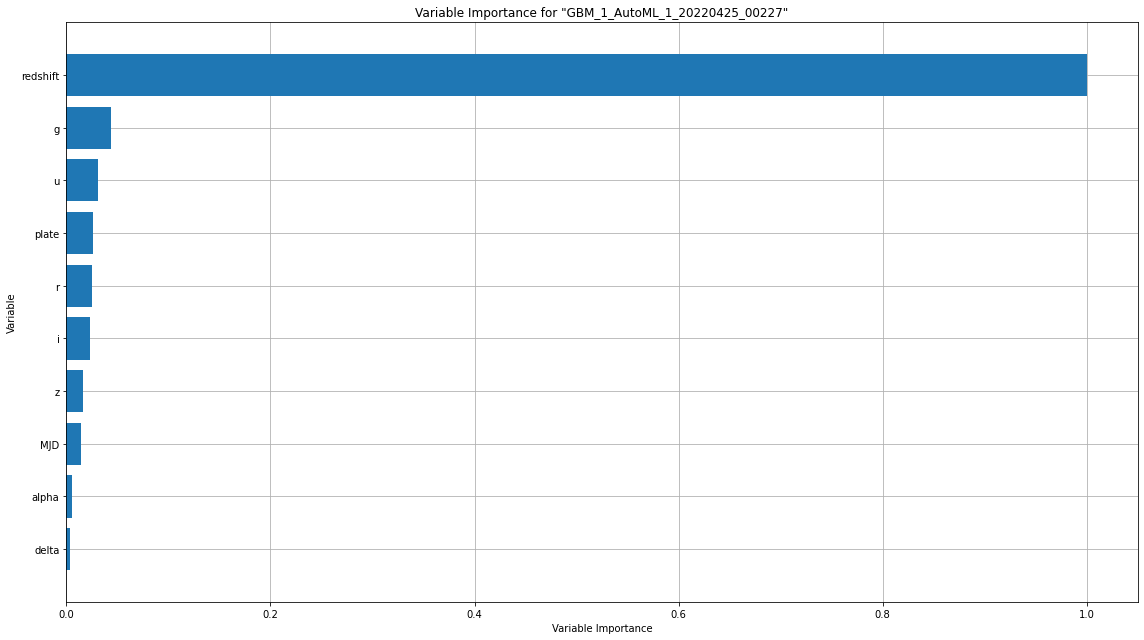

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

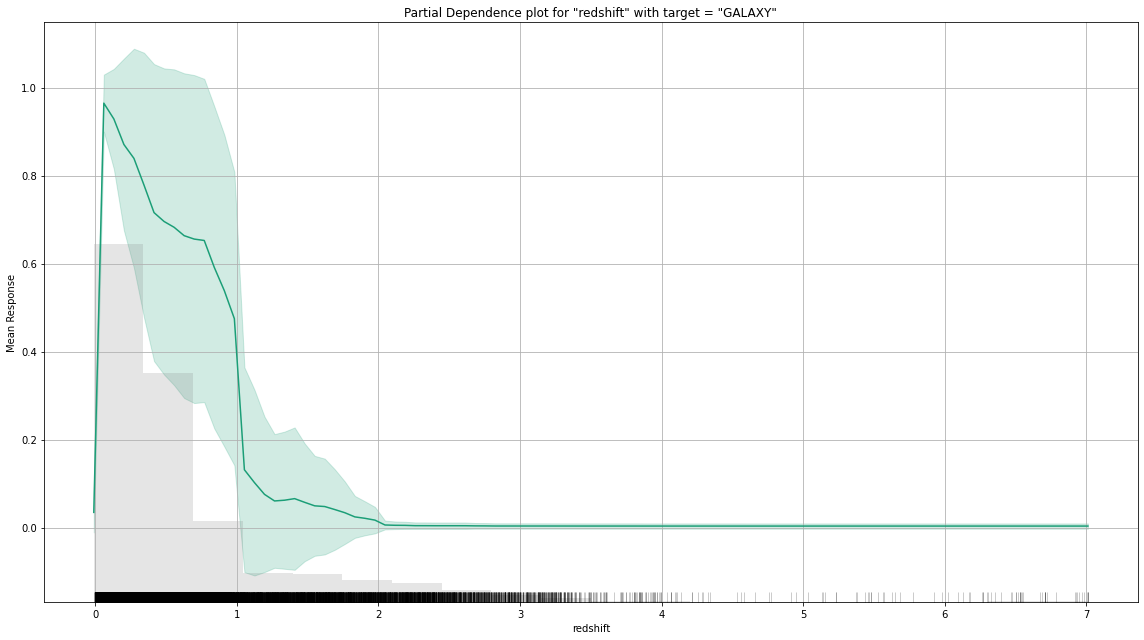

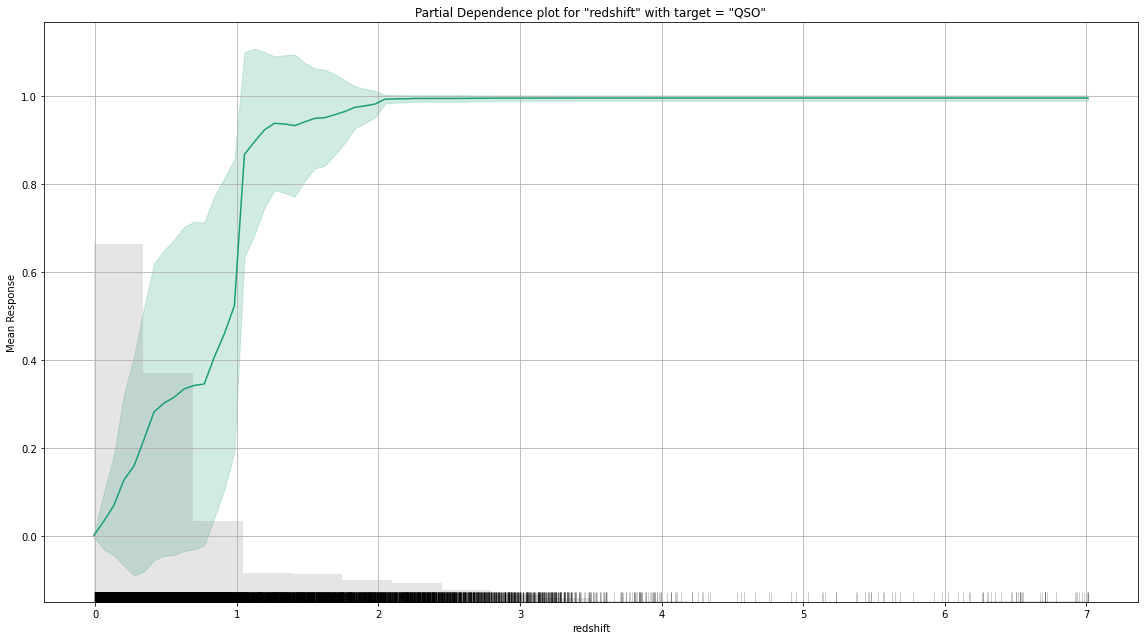

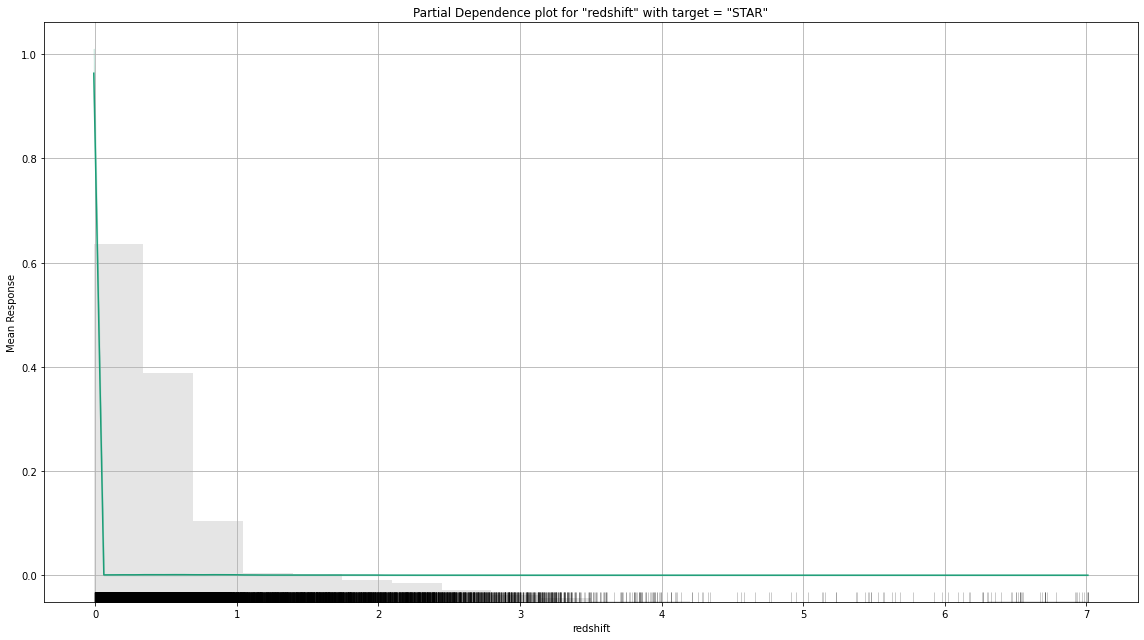

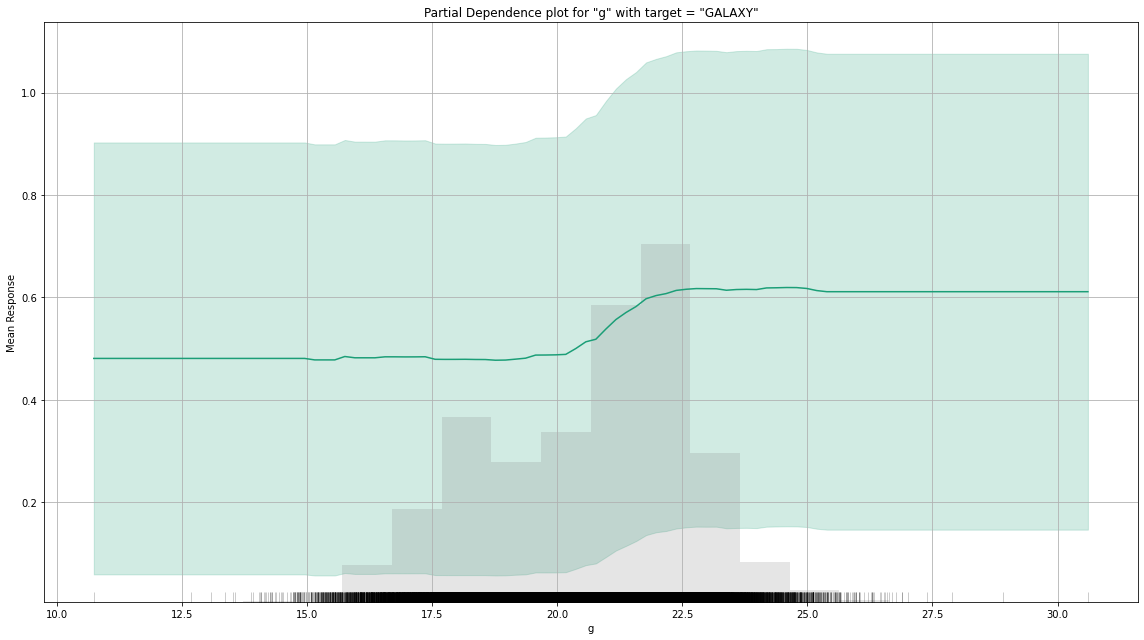

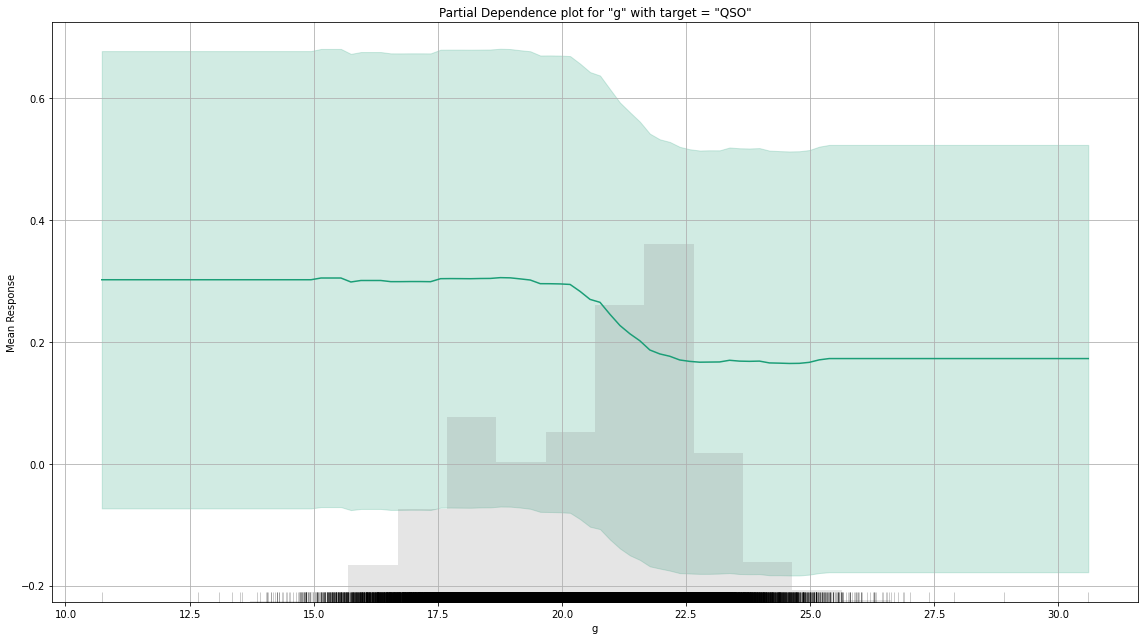

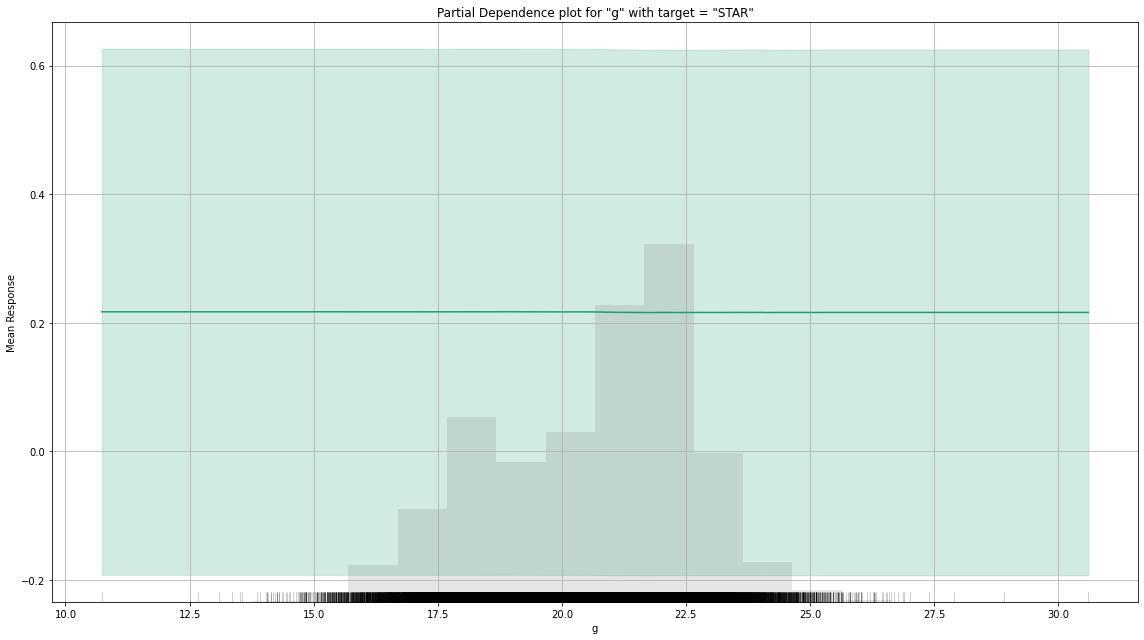

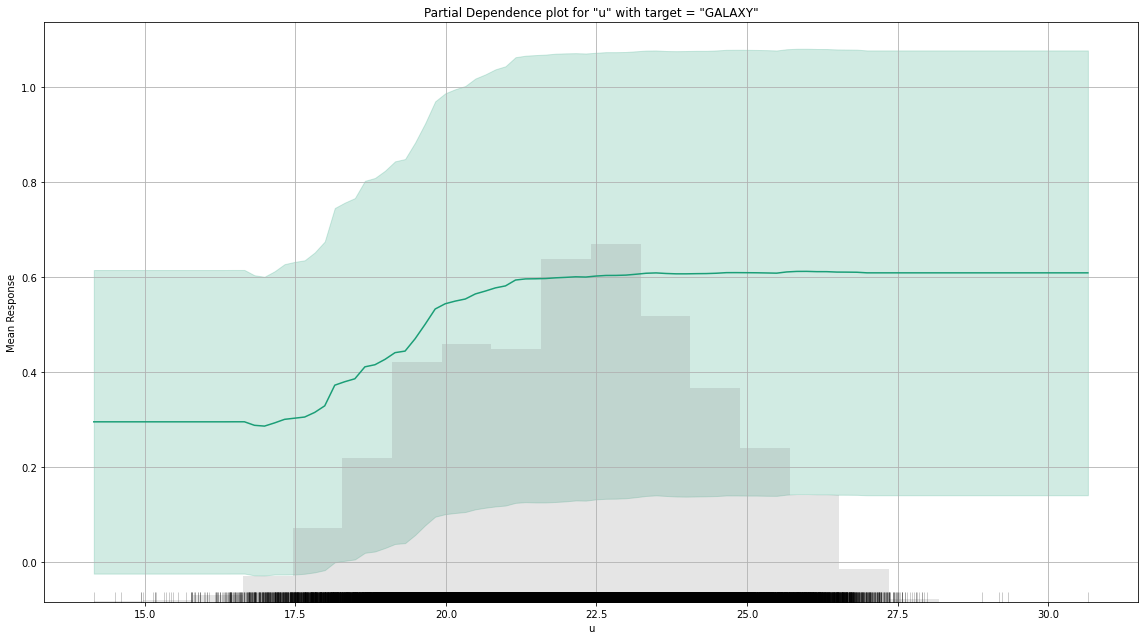

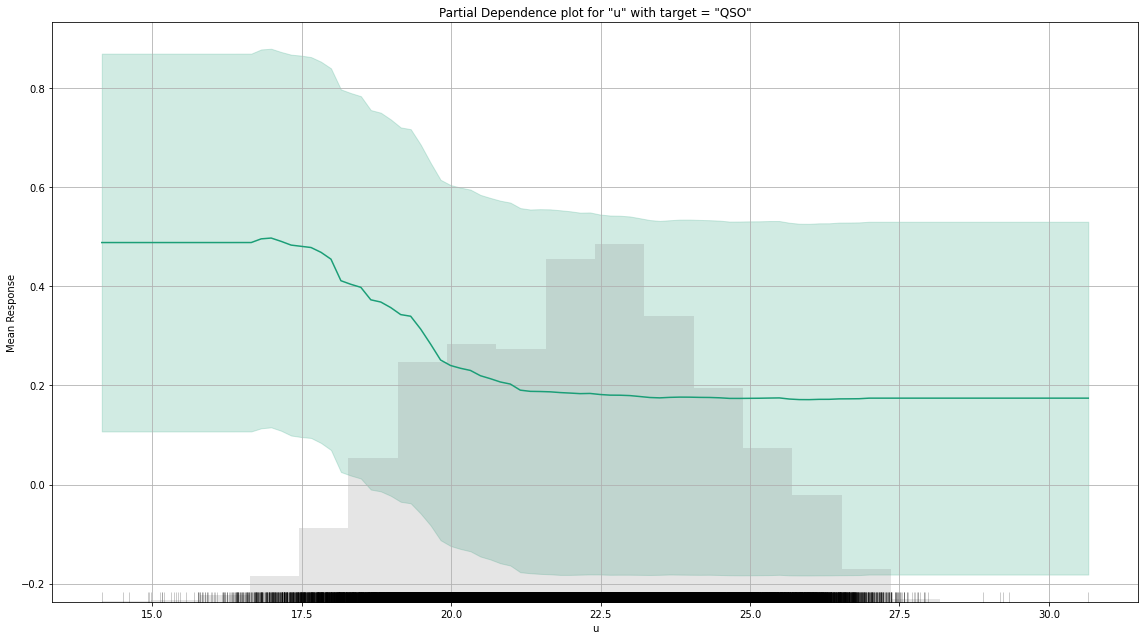

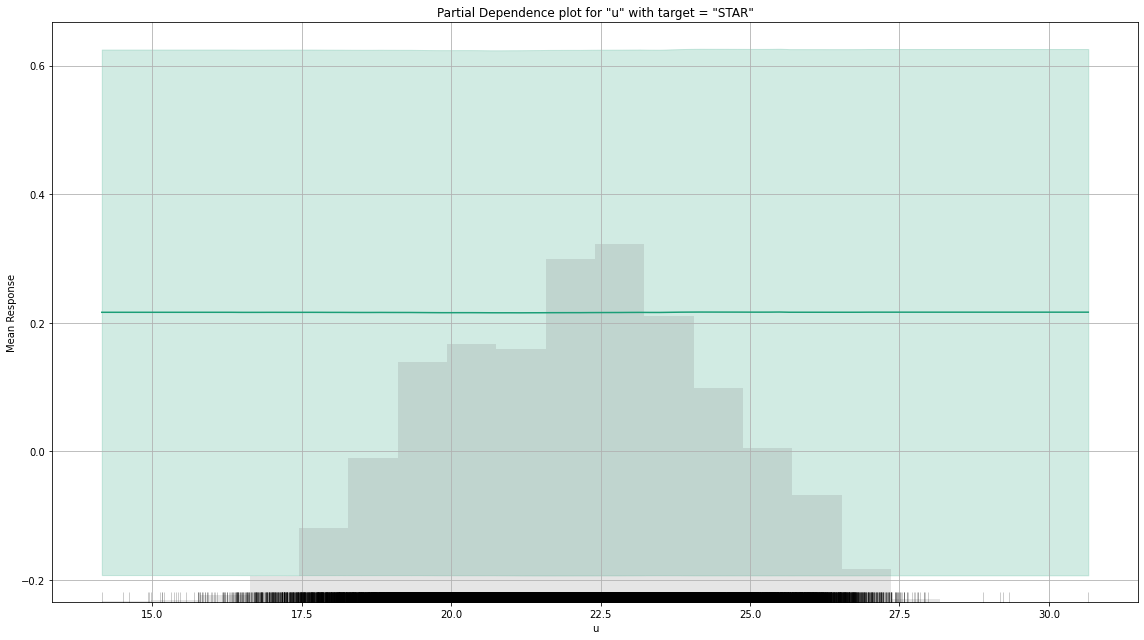

In [ ]:
model_explain = m.explain(test_factor, top_n_features=3)

How well I did?
> I found the important features for the model is redshift, found 3 groups of correlated variables then droped them. I found no empty values but found some outliers and cleaned them. I also built 3 models with 0.93,0.94, 0.99 accuracy on testing samples. I explained their parameters to make them reasonable, and used SHAP tho show importance of my selected variables.

**Conclusion**(what I learnt)

In these assignment, I cleaned data, explained the meaning of data and selected most important features, finding correlationship. Then I built up 3 models and interpreted these models, explained their parameters and SHAP. I learnt the whole process of solving a problem.